## Dataset
First, we will load the diabetes dataset using the load_diabetes function from sklearn.datasets. The dataset consists of 10 baseline variables, age, sex, body mass index, average blood pressure, and six blood serum measurements, and a quantitative measure of disease progression one year after baseline.

In [13]:
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoLarsIC
from sklearn.pipeline import make_pipeline
import pandas as pd
import numpy as np

In [14]:
X, y = load_diabetes(return_X_y=True, as_frame=True)
X.head(1)

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.05068,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646


## Adding Random Features
We will add some random features to the original data to better illustrate the feature selection performed by the Lasso model. Random features will be generated using the RandomState function from numpy.

In [15]:
import numpy as np
import pandas as pd

rng = np.random.RandomState(42)
n_random_features = 14
X_random = pd.DataFrame(
    rng.randn(X.shape[0], n_random_features),
    columns=[f"random_{i:02d}" for i in range(n_random_features)],
)
X = pd.concat([X, X_random], axis=1)
X[X.columns[::3]].head(1)

,age,bp,s3,s6,random_02,random_05,random_08,random_11
0,0.038076,0.021872,-0.043401,-0.017646,0.647689,-0.234137,-0.469474,-0.46573


## Selecting Lasso via an Information Criterion
We will use the LassoLarsIC function from sklearn.linear_model to provide a Lasso estimator that uses the Akaike information criterion (AIC) or the Bayes information criterion (BIC) to select the optimal value of the regularization parameter alpha. We will first fit a Lasso model with the AIC criterion.

In [16]:
import time
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoLarsIC
from sklearn.pipeline import make_pipeline

start_time = time.time()
lasso_lars_ic = make_pipeline(StandardScaler(), LassoLarsIC(criterion="aic")).fit(X, y)
fit_time = time.time() - start_time

## Storing Results and Checking Optimal Alpha
We will store the AIC metric for each value of alpha used during fit. We will then perform the same analysis using the BIC criterion. Finally, we will check which value of alpha leads to the minimum AIC and BIC.

In [17]:
results = pd.DataFrame(
    {
        "alphas": lasso_lars_ic[-1].alphas_,
        "AIC criterion": lasso_lars_ic[-1].criterion_,
    }
).set_index("alphas")
alpha_aic = lasso_lars_ic[-1].alpha_

lasso_lars_ic.set_params(lassolarsic__criterion="bic").fit(X, y)
results["BIC criterion"] = lasso_lars_ic[-1].criterion_
alpha_bic = lasso_lars_ic[-1].alpha_

def highlight_min(x):
    x_min = x.min()
    return ["font-weight: bold" if v == x_min else "" for v in x]

results.style.apply(highlight_min)

,AIC criterion,BIC criterion
alphas,,
45.160030,5244.764779,5244.764779
42.300343,5208.250639,5212.341949
21.542052,4928.018900,4936.201520
15.034077,4869.678359,4881.952289
6.189631,4815.437362,4831.802601
5.329616,4810.423641,4830.880191
4.306012,4803.573491,4828.121351
4.124225,4804.126502,4832.765671
3.820705,4803.621645,4836.352124


## Plotting AIC and BIC Values
Finally, we will plot the AIC and BIC values for the different alpha values. The vertical lines in the plot correspond to the alpha chosen for each criterion. The selected alpha corresponds to the minimum of the AIC or BIC criterion.

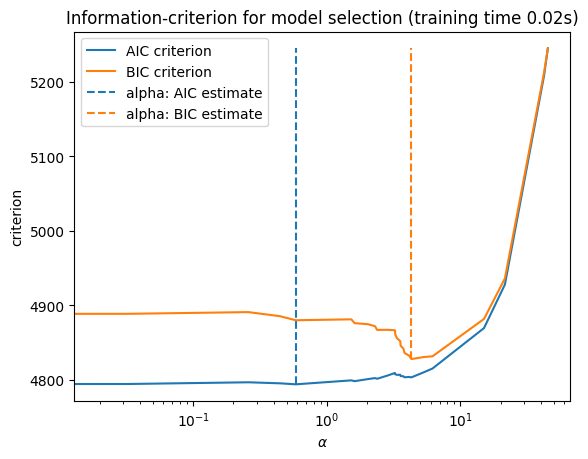

In [18]:
ax = results.plot()
ax.vlines(
    alpha_aic,
    results["AIC criterion"].min(),
    results["AIC criterion"].max(),
    label="alpha: AIC estimate",
    linestyles="--",
    color="tab:blue",
)
ax.vlines(
    alpha_bic,
    results["BIC criterion"].min(),
    results["BIC criterion"].max(),
    label="alpha: BIC estimate",
    linestyle="--",
    color="tab:orange",
)
ax.set_xlabel(r"$\alpha$")
ax.set_ylabel("criterion")
ax.set_xscale("log")
ax.legend()
_ = ax.set_title(
    f"Information-criterion for model selection (training time {fit_time:.2f}s)"
)

## Selecting Lasso via Cross-Validation
We will use two different estimators to select the best hyperparameter alpha with integrated cross-validation: LassoCV and LassoLarsCV. For both algorithms, we will use a 20-fold cross-validation strategy.

## Lasso via Coordinate Descent
We will make the hyperparameter tuning using LassoCV.

In [19]:
from sklearn.linear_model import LassoCV

start_time = time.time()
model = make_pipeline(StandardScaler(), LassoCV(cv=20)).fit(X, y)
fit_time = time.time() - start_time

## Lasso via Least Angle Regression
We will make the hyperparameter tuning using LassoLarsCV.

In [20]:
from sklearn.linear_model import LassoLarsCV

start_time = time.time()
model = make_pipeline(StandardScaler(), LassoLarsCV(cv=20)).fit(X, y)
fit_time = time.time() - start_time

import warnings
from sklearn.exceptions import ConvergenceWarning

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    model = make_pipeline(StandardScaler(), LassoLarsCV(cv=20)).fit(X, y)

## Summary of Cross-Validation Approach
* Both algorithms give roughly the same results.
* Lars computes a solution path only for each kink in the path. As a result, it is very efficient when there are only of few kinks, which is the case if there are few features or samples.
* On the opposite, coordinate descent computes the path points on a pre-specified grid (here we use the default).
* Thus it is more efficient if the number of grid points is smaller than the number of kinks in the path.
* Such a strategy can be interesting if the number of features is really large and there are enough samples to be selected in each of the cross-validation fold.
* In terms of numerical errors, for heavily correlated variables, Lars will accumulate more errors, while the coordinate descent algorithm will only sample the path on a grid.

| 流程步驟 | 重點 |
|---------|------|
| **1. 讀資料** | 用 `load_diabetes` 把 442 筆病患資料載進來（10 個原始特徵 + 目標 y）。 |
| **2. 加亂數特徵** | 再塞 **14 個隨機欄位**，故意干擾 → 等下看 Lasso 能不能把它們踢掉。 |
| **3. 用 AIC / BIC 挑 Lasso** | `LassoLarsIC` 一次掃過整條 α 路徑： <br>  •  算出每個 α 的 **AIC / BIC** 分數 <br>  •  找到分數最低的 α（圖上兩條虛線） |
| **4. 結果觀察** | AIC 通常選 **較小 α → 模型較複雜**；BIC 偏愛 **較大 α → 模型較精簡**。|
| **5. 交叉驗證 PK** | 再用 `LassoCV`（座標下降） 與 `LassoLarsCV`（LARS）做 20 折 CV： <br>  •  兩者 α 差不多 <br>  •  **LARS**：只在「轉折點」算解 → 特徵少時超快 <br>  •  **座標下降**：先定好 α 網格 → 若網格少、特徵多時更快 |
| **6. 速度&誤差比較** | - LARS 可能累積誤差（特徵高度相關時） <br> - 座標下降較穩，但要小心網格太粗會漏掉好 α |

---

#### 什麼時候用哪一招？
| 場景 | 推薦方法 | 為什麼 |
|------|----------|--------|
| 特徵不多、想快點挑 α | **LassoLarsIC** + AIC/BIC 或 **LassoLarsCV** | 路徑轉折點少，LARS 跑很快；IC 又省下 CV。 |
| 特徵超多 (上千)、資料夠多 | **LassoCV** (座標下降) | 網格點 < 轉折點 → 反而最快；數值也較穩。 |
| 不想切驗證集 / 資料太小 | **LassoLarsIC** (AIC/BIC) | 不用 CV，省資料、省時間。 |

---

> **一句話**  
> 加了 14 個亂數特徵之後，Lasso + AIC/BIC 依然能「嗅」出真正有用的變數；若時間充裕也能用交叉驗證 double-check，兩種方法各有快慢與穩定度取捨。
